# Notebook 3: Simple troubleshooting

Curious if your acquisition went well? Suspicious that something is wrong? Here are two things I like to check.

- Time histogram
- Missed images

## Imports

<div class="alert alert-block alert-info">
<b>Why "cd ..":</b> We move the working directory upwards one so you can access source code in iqid/. This step is necessary because iqid hasn't been set up as an installable package (i.e. via pip or conda), reflecting the fact that it's pretty informal and (permanently) in development.
</div>

In [1]:
cd ..

C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas


In [2]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage import io

%load_ext autoreload
%autoreload 2
from iqid import helper as iq # helper functions such as plotting parameters and other things
from iqid import process_object as po # class to handle listmode data is contained here.

pltmap = iq.set_plot_parms() # set default plot settings (feel free to change this)

C:\Users\Robin\anaconda3\envs\beq\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Load data
- Follows the procedure outlined in Demo Notebook 1.

## 1. Time histogram
We expect to see a nice exponential decay corresponding to the half-life of the isotope that you used. Let's look at a good example first.

*note that if you run the next examples and come back to this one, you'll have to re-import the data.*

In [3]:
%%time

# enter the path to your iQID data on your machine
datdir = r"C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas\data_sample\File_Structure_Sample"
fname = iq.natural_sort(glob.glob(os.path.join(datdir, "Listmode", "*Compressed_Processed_Listmode.dat")))[-1]
cdat = po.ClusterData(fname, ftype="processed_lm", c_area_thresh=1)
cim = cdat.image_from_big_listmode(event_fx=1)

CPU times: total: 2.73 s
Wall time: 3.03 s


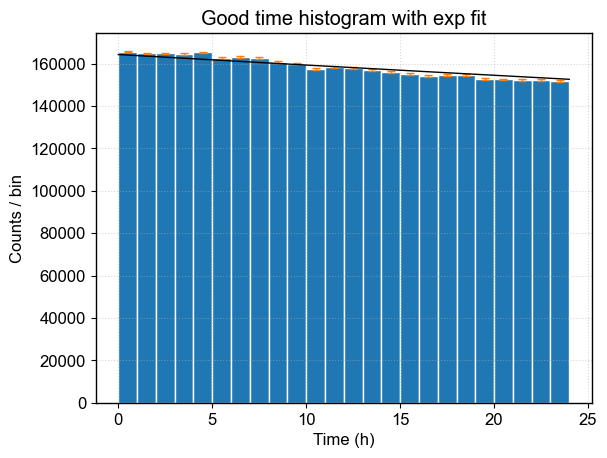

In [4]:
# regardless of what time unit you decide to use, make sure it's consistent for all arrays
thalf = 9.9 * 24 # time 
tdata = cdat.t_s / 60 / 60 # timestamps of each recorded event in hours
t_binsize = 1 # 1-hour binsize -- adjust if needed
nbins = int(np.round((tdata[-1] - tdata[0])/t_binsize))

# generate histogram
n, bins, _ = plt.hist(tdata, bins=nbins, edgecolor='white')
binedges = 0.5 * (bins[1:] + bins[:-1])

# fit the histogram with an exponential decay
popt, pcov, param_std, res, chisq, chisqn = cdat.fitHist(
    binedges, n, func=po.exponential, p0=[1, thalf], tol=0.05)

# generate dummy array to plot the exponential
tdummy = np.linspace(tdata[0], tdata[-1], 5000)

# plot the components on top of the histogram
plt.errorbar(binedges, n, np.sqrt(n), linestyle='none', capsize=3) # errorbars
plt.plot(tdummy, po.exponential(tdummy, *popt), color='k')
plt.xlabel('Time (h)')
plt.ylabel('Counts / bin')
plt.title('Good time histogram with exp fit')
plt.show()

This histogram appears to be reasonably fit with the half-life of Ac-225 (to within 5% tolerance). There are no obvious spikes or missing data during the acquisition. Note that because 10 d is a long half-life, it will look fairly linear over a 24-h acquisition. Looks good to me!

What might a bad example look like and what would it tell you about the data?

In [5]:
datdir = r"C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas\data_sample\File_Structure_Sample_Bad"
fname = iq.natural_sort(glob.glob(os.path.join(datdir, "Listmode", "*Compressed_Processed_Listmode.dat")))[-1]
cdat = po.ClusterData(fname, ftype="processed_lm", c_area_thresh=1)
cim = cdat.image_from_big_listmode(event_fx=1)

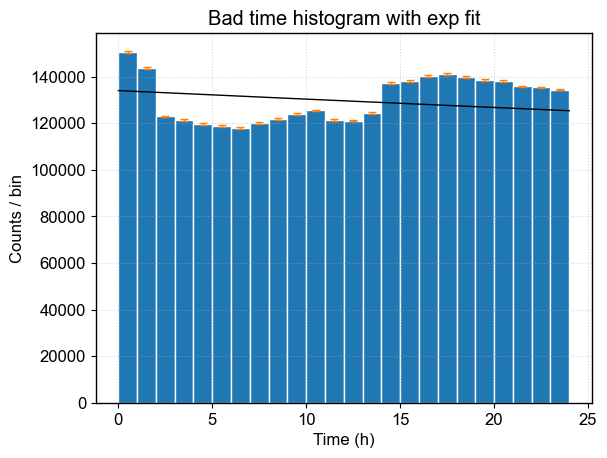

In [6]:
tdata = cdat.t_s / 60 / 60 # timestamps of each recorded event in hours
nbins = int(np.round((tdata[-1] - tdata[0])/t_binsize))

# generate histogram
n, bins, _ = plt.hist(tdata, bins=nbins, edgecolor='white')
binedges = 0.5 * (bins[1:] + bins[:-1])

# fit the histogram with an exponential decay
popt, pcov, param_std, res, chisq, chisqn = cdat.fitHist(
    binedges, n, func=po.exponential, p0=[1, thalf], tol=0.05)

# generate dummy array to plot the exponential
tdummy = np.linspace(tdata[0], tdata[-1], 5000)

# plot the components on top of the histogram
plt.errorbar(binedges, n, np.sqrt(n), linestyle='none', capsize=3) # errorbars
plt.plot(tdummy, po.exponential(tdummy, *popt), color='k')
plt.xlabel('Time (h)')
plt.ylabel('Counts / bin')
plt.title('Bad time histogram with exp fit')
plt.show()

We can see that this histogram does not follow a nice exponential decay like the last one, instead showing a dip in signal from 3h-14h. One guess for why this might have happened is if the laptop had some kind of scheduled update or power setting that made it divert computational resources during that time. Data like this may still be quantitatively recoverable with some further analysis. Since there's still a lot of counts, the image itself should be fine. Let's see below:

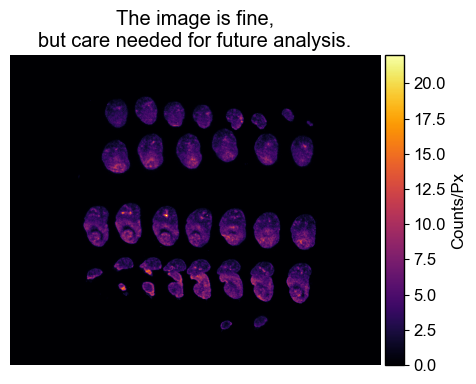

In [7]:
f, ax = plt.subplots(1,1, figsize=(8,4))
im = ax.imshow(cim, cmap='inferno', vmax=0.5*np.max(cim))
ax.axis('off')

cbar = iq.nice_colorbar(im)
cbar.set_label('Counts/Px')

plt.title('The image is fine,\nbut care needed for future analysis.')
plt.tight_layout()
plt.show()
plt.close()

## 2. Missed images

In the iQID header file, you can check the last line to see if any images (frames) were missed during the acquisition. Significant (>100) missed frames can indicate something went wrong. Sometimes, if the acquisition doesn't stop correctly, the missed image warning at the bottom of the header file will be missing. We can check manually using the Offsets Listmode file.

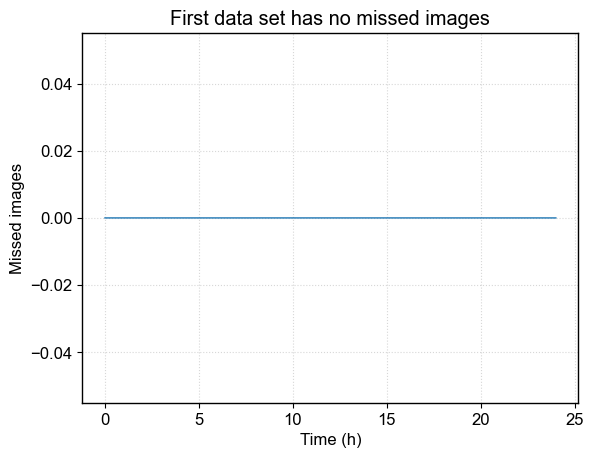

In [8]:
# first: good example with no missed images
datdir = r"C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas\data_sample\File_Structure_Sample"

# note, using the Offsets file instead
oname = glob.glob(os.path.join(datdir,'Listmode', '*Offsets_Full_Raw_Listmode.dat'))[-1]
odat = po.ClusterData(oname, ftype="offset_lm")
data = odat.load_cluster_data(dtype=np.int32)
f_of, t, m, n, px, kelv = odat.init_metadata(data)

# plot missed images over time
plt.plot(t * 1e-3 / 3600, m)
plt.xlabel('Time (h)')
plt.ylabel('Missed images')
plt.title('First data set has no missed images')
plt.show()

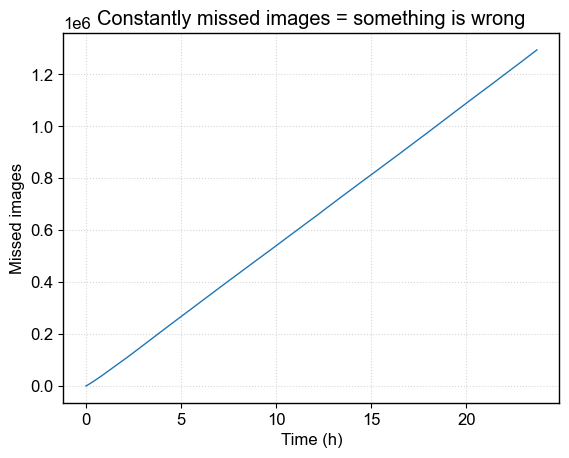

In [9]:
# next: example with missed images
datdir = r"C:\Users\Robin\Documents\Cal\iQID\git_branches\iqid-alphas\data_sample\File_Structure_Sample_Missed"

# note, using the Offsets file instead
oname = glob.glob(os.path.join(datdir,'Listmode', '*Offsets_Full_Raw_Listmode.dat'))[-1]
odat = po.ClusterData(oname, ftype="offset_lm")
data = odat.load_cluster_data(dtype=np.int32)
f_of, t, m, n, px, kelv = odat.init_metadata(data)

# plot missed images over time
plt.plot(t * 1e-3 / 3600, m)
plt.xlabel('Time (h)')
plt.ylabel('Missed images')
plt.title('Constantly missed images = something is wrong')
plt.show()

In this data, we were having issues with the old iQID laptop as well as connection via USB. There will be some problems doing quantitative dosimetry with this.

In some datasets, there might just be one spike of missed images. This is usually recoverable but it's a case-by-case basis.

# Okay... but what do we do if we have these problems?
- It's a case-by-case basis
- Feel free to reach out with specific inquiries
- *Some* functionality is available to recover data in certain cases